In [27]:
import math

In [31]:
class Value(object):
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0

    def __repr__(self):
        return (f'data: {self.data}')

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+", '')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*", '')
        return out

    def tanh(self):
        x = self.data
        val = (math.exp(x) -  math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(val, (self,), "tanh", '')
        return out

In [32]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [33]:
def trace(root):
    nodes, edges = set(), set()
    def dfs(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                dfs(child)

    dfs(root)
    return nodes, edges

In [34]:
trace(d)

({data: -3.0, data: -6.0, data: 10.0, data: 2.0, data: 4.0},
 {(data: -3.0, data: -6.0),
  (data: -6.0, data: 4.0),
  (data: 10.0, data: 4.0),
  (data: 2.0, data: -6.0)})

In [35]:
from graphviz import Digraph

In [36]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    # draw nodes
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    # draw edges to the nodes
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

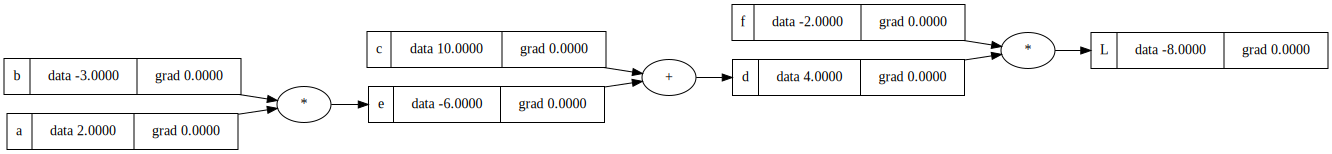

In [37]:
draw_dot(L)

In [8]:
L.grad = 1.0  # manual backprop, dL/dL is 1.0

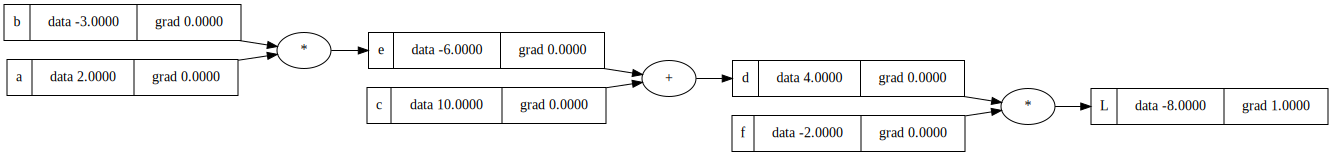

In [9]:
draw_dot(L)

dL/dL = 1

L = d * f \
dL/df = d \
dL/dd = f <br><br/>
dd/dc = 1 \
dd/de = 1 \
dL/dc = dL/dd * dd/dc = dL/dd \
dL/de = dL/dd * dd/de = dL/dd <br><br/>
de/db = a \
de/da = b \
dL/db = dL/de * de/db = dL/de * a \
dL/da = dL/de * de/da = dL/de * b 

In [10]:
f.grad = d.data
d.grad = f.data

c.grad = d.grad
e.grad = d.grad

b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [11]:
print(f.grad)
print(d.grad)
print(c.grad)
print(e.grad)
print(b.grad)
print(a.grad)

4.0
-2.0
-2.0
-2.0
-4.0
6.0


In [18]:
h = 0.001

# use this lol function to check the derivative
def lol():
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    f = Value(-2.0, label='f')
    e = a * b; c.label='e'
    d = e + c; d.label='d'
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    f = Value(-2.0, label='f')
    e = a * b; c.label='e'
    d = e + c; d.label='d'
    # d.data += h
    # f.data += h
    L = d * f; L.label = 'L'
    L2 = L.data
    
    derivative = (L2 - L1) / h
    print(derivative)

lol()

-3.9999999999995595


In [17]:
# move in the direction of the gradient to increment L

a.data += 0.01 * a.grad 
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; c.label='e'
d = e + c; d.label='d'
L = d * f; L.label = 'L'
# we expect a less negative L
print(L)

data: -6.586368000000001


In [45]:
# Backprop
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')
b = Value(6.8814, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

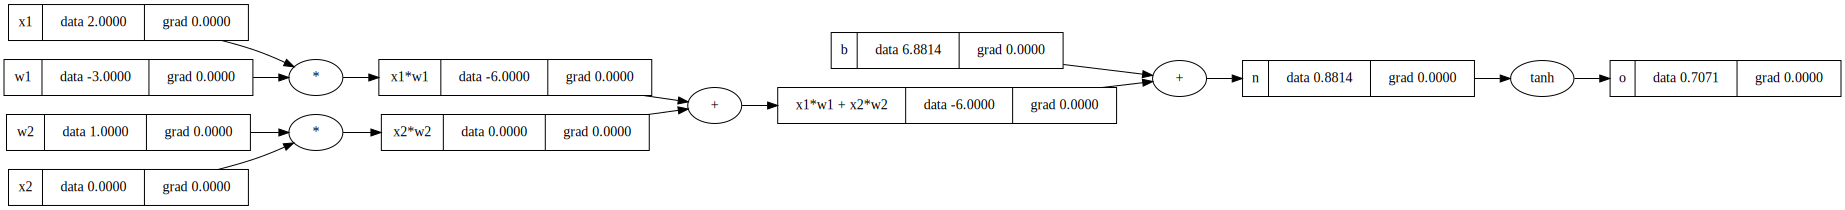

In [46]:
draw_dot(o)

Karpathy said that when building the "operation" nodes the complexity of the operation can have arbitrary atomicity, for example when building the tanh node, we do not have to break it down into its exponentiation elements. As long as we can take the local derivative to the operation it will be fine.

In [48]:
# derivative of tanh is approx. 0.5 with the value of b given
1 - o.data**2

0.4999813233768231

In [50]:
# manual derivative
o.grad = 1.0
n.grad = o.grad * 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad 
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [15]:
a

data: 2.06

In [16]:
b

data: -3.04